In [1]:
import requests

import json
import os

In [2]:
import pandas as pd

In [3]:
import sys, traceback
import mwreverts.api
import mwapi

# We'll use the mwreverts API check.  In order to do that, we need an API session
session = mwapi.Session("https://en.wikipedia.org", 
                        user_agent="Max Klein Newcomer Quality <max@notconfusing.com>")

In [161]:
import datetime as dt


from collections import defaultdict

from sklearn_pandas import DataFrameMapper, cross_val_score


import pandas as pd
pd.set_option('display.max_colwidth', 250)
import numpy as np
import sklearn.preprocessing, sklearn.linear_model, sklearn.metrics, sklearn.ensemble
import sklearn.model_selection


In [5]:
endpoint = 'https://labels.wmflabs.org/campaigns/'

resp = requests.get(url=endpoint)
data = resp.json()

wikis = data['wikis']

mdtp_campaigns = {}

mdtp_tasks = {}

In [6]:
for wiki in wikis:
    wiki_endpoint = f'{endpoint}{wiki}'
#     print(wiki_endpoint)
    wiki_resp = requests.get(wiki_endpoint)
    wiki_data = wiki_resp.json()
    for campaign in wiki_data['campaigns']:
        if campaign['view'] == 'MultiDiffToPrevious':
            mdtp_campaigns[wiki] = campaign['id']

In [302]:
for k, v in mdtp_campaigns.items():
    campaign_endpoint = f'{endpoint}{k}/{v}/?tasks'
    print(campaign_endpoint)
    campaign_resp = requests.get(campaign_endpoint)
    campaign_data = campaign_resp.json()
    mdtp_tasks[k] = campaign_data['tasks']


for wiki, tasks in mdtp_tasks.items():
    print(f'wiki:{wiki}')
    completed = [t for t in tasks if t['labels']]
    with open('enwiki_newcomer_labelled_100.jsonl','w') as outf:
        for l in completed:
            rev_ids = l['data']['rev_ids']
            labels = l['labels'][0]['data']
            id_labels = {'rev_ids':rev_ids, **labels}
            outf.write(json.dumps(id_labels))
            outf.write('\n')
    print(f'{len(completed)} completed tasks of {len(tasks)} total')
#     for task in tasks:
#         lab = task['labels']
#         if lab:
#             print(lab)

https://labels.wmflabs.org/campaigns/enwiki/86/?tasks
wiki:enwiki
416 completed tasks of 1989 total


# Check the singletons

In [304]:
def perc_singleton(fname):
    rev_lens = []
    with open(fname,'r') as f:
        for line in f:
            d = json.loads(line)
            rev_ids  = d['rev_ids']
            rev_lens.append(len(rev_ids))

    num_singleton = len([l for l in rev_lens if l==1])
    perc_singleton =  num_singleton / len(rev_lens)
    return num_singleton, perc_singleton

In [305]:
jsonls = [f for f in os.listdir('.') if f.endswith('.jsonl')]
for jsonl in jsonls:
    print(jsonl, perc_singleton(jsonl))

enwiki_newcomer_labelled_100.jsonl (213, 0.5120192307692307)


# Get ORES data

In [306]:
completed_row_oriented = [{'task_id': c['id'],
                            'user_id':c['data']['user_id'],
                           'rev_ids':c['data']['rev_ids'],
                           'damaging_label':c['labels'][0]['data']['damaging'],
                           'goodfaith_label':c['labels'][0]['data']['goodfaith'],} for c in completed]

In [307]:
df = pd.DataFrame.from_dict(completed_row_oriented)

In [308]:
df = df[pd.notnull(df['goodfaith_label']) & pd.notnull(df['damaging_label'])] #no skipped ones

In [309]:
ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'
context = 'enwiki'
models = ('damaging', 'goodfaith')

In [310]:
def get_ores_data_dgf(rev_ids):
    print(f'getting {len(rev_ids)} revs')
    ores_data = {}
    for model in ('damaging', 'goodfaith'):
        ores_data[model] = []
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data

In [311]:
sdf = df[:10]

In [312]:
%time sdf['ores_data'] = sdf['rev_ids'].apply(get_ores_data_dgf)

getting 1 revs
getting 5 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 3 revs
CPU times: user 1.07 s, sys: 72.8 ms, total: 1.15 s
Wall time: 12.7 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [313]:
sdf.iloc[1]['ores_data']

{'damaging': [{'prediction': False, 'prob_true': 0.09601118263157825},
  {'prediction': False, 'prob_true': 0.23005538799402592},
  {'prediction': False, 'prob_true': 0.3725931153402145},
  {'prediction': False, 'prob_true': 0.2364148442188683},
  {'prediction': False, 'prob_true': 0.3605051146114929}],
 'goodfaith': [{'prediction': True, 'prob_true': 0.9829427927492975},
  {'prediction': True, 'prob_true': 0.9641269434220542},
  {'prediction': True, 'prob_true': 0.9637834671582234},
  {'prediction': True, 'prob_true': 0.8775891764561563},
  {'prediction': True, 'prob_true': 0.9341377634684186}]}

In [314]:
df['ores_data'] = df['rev_ids'].apply(get_ores_data_dgf)

getting 1 revs
getting 5 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 3 revs
getting 5 revs
getting 3 revs
getting 1 revs
getting 2 revs
getting 2 revs
getting 3 revs
getting 1 revs
getting 2 revs
getting 2 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 2 revs
getting 2 revs
getting 1 revs
getting 1 revs
getting 2 revs
getting 72 revs
getting 1 revs
getting 3 revs
getting 2 revs
getting 12 revs
getting 1 revs
getting 1 revs
getting 3 revs
getting 2 revs
getting 3 revs
getting 1 revs
getting 2 revs
getting 3 revs
getting 3 revs
getting 1 revs
getting 2 revs
getting 1 revs
getting 5 revs
getting 1 revs
getting 1 revs
getting 3 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 3 revs
getting 1 revs
getting 6 revs
getting 1 revs
getting 3 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 

In [315]:
df.to_pickle('saves/exp_v1_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v1_with_ores_scores.pickle')

In [316]:
df.head()

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data
0,False,True,[764113608],558731,30282906,"{'damaging': [{'prediction': False, 'prob_true': 0.15501228732476371}], 'goodfaith': [{'prediction': True, 'prob_true': 0.976423405666497}]}"
1,False,True,"[763924694, 763926307, 763930716, 763931301, 763932010]",558733,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.09601118263157825}, {'prediction': False, 'prob_true': 0.23005538799402592}, {'prediction': False, 'prob_true': 0.3725931153402145}, {'prediction': False, 'prob_true': 0.2364148442188683}, {'pred..."
2,False,True,"[764251399, 764252150, 764253295, 764257845]",558734,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.04356904152227608}, {'prediction': False, 'prob_true': 0.4711299401055051}, {'prediction': False, 'prob_true': 0.22013728098376725}, {'prediction': False, 'prob_true': 0.06750852803308395}], 'goo..."
3,False,True,[763918492],558737,30282924,"{'damaging': [{'prediction': True, 'prob_true': 0.6152127780999527}], 'goodfaith': [{'prediction': True, 'prob_true': 0.5972110083906026}]}"
4,False,True,[763917983],558741,30282943,"{'damaging': [{'prediction': False, 'prob_true': 0.27870679674580473}], 'goodfaith': [{'prediction': True, 'prob_true': 0.8745512035659346}]}"


In [317]:
df['damaging_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['goodfaith'] if isinstance(e, dict)])
df['damaging_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['goodfaith'] if isinstance(e, dict)])

In [318]:
df = df[df['damaging_scores'].apply(lambda l:len(l)>0)] # drop out nan results

In [319]:
df['goodfaith_session_edit_mismatch'] = df[['goodfaith_label','goodfaith_predictions']].apply(lambda row: not(row['goodfaith_label'] in row['goodfaith_predictions']), axis=1)
df['damaging_session_edit_mismatch'] = df[['damaging_label','damaging_predictions']].apply(lambda row: not(row['damaging_label'] in row['damaging_predictions']), axis=1)

In [320]:
goodfaith_mismatches = df[df['goodfaith_session_edit_mismatch']==True]
damaging_mismatches = df[df['damaging_session_edit_mismatch']==True]

In [321]:
print(f'len goodfaith mistmatches: {len(goodfaith_mismatches)}')
print(f'len damaging mistmatches: {len(damaging_mismatches)}')

len goodfaith mistmatches: 55
len damaging mistmatches: 72


In [322]:
def wlink(rev_id):
    return f'https://en.wikipedia.org/w/index.php?diff=prev&oldid={rev_id}&diffmode=source'

In [323]:
goodfaith_mismatches['wlinks'] = goodfaith_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])
damaging_mismatches['wlinks'] = damaging_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [324]:
goodfaith_mismatches[goodfaith_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
25,True,False,"[763926298, 763926606]",558838,30283258,"{'damaging': [{'prediction': False, 'prob_true': 0.4730587747991271}, {'prediction': True, 'prob_true': 0.7440500123958258}], 'goodfaith': [{'prediction': True, 'prob_true': 0.6616573843599153}, {'prediction': True, 'prob_true': 0.575930360909807...","[0.4730587747991271, 0.7440500123958258]","[0.6616573843599153, 0.5759303609098076]","[False, True]","[True, True]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926298&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926606&diffmode=source]"
29,True,True,"[763929270, 763930145]",558858,30283361,"{'damaging': [{'prediction': True, 'prob_true': 0.7183727092044194}, {'prediction': True, 'prob_true': 0.8418168665142072}], 'goodfaith': [{'prediction': False, 'prob_true': 0.372561553827677}, {'prediction': False, 'prob_true': 0.319276701933801...","[0.7183727092044194, 0.8418168665142072]","[0.372561553827677, 0.3192767019338014]","[True, True]","[False, False]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763929270&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763930145&diffmode=source]"
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9

In [325]:
damaging_mismatches[damaging_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
43,False,False,"[763934049, 763934196, 763934324]",558894,30283552,"{'damaging': [{'prediction': True, 'prob_true': 0.7762776688360993}, {'prediction': True, 'prob_true': 0.6276607010744235}, {'prediction': True, 'prob_true': 0.7407605345081835}], 'goodfaith': [{'prediction': False, 'prob_true': 0.291930650099069...","[0.7762776688360993, 0.6276607010744235, 0.7407605345081835]","[0.2919306500990693, 0.5073118633667208, 0.4407799468961656]","[True, True, True]","[False, True, False]",False,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934049&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934196&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934324&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9097528002582813, 0.8942124644148761]","[False, False, False, False, False]","[True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945255&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945337&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763947098&diffmode=source, https..."
80,True,False,"[764004719, 764006056]",559073,30284320,"{'damaging': [{'predictio

# TODO:Try a new label where the singletons are just the ores label

##  Get timestamps #

In [326]:
def get_rev_timestamps(revids):
    timestamps = []
    pages = []
    if len(revids)>50:
        print('truncating to 50 revids')
        revids=revids[:49]
    rev_query = session.get(action='query', prop='revisions', revids=revids)
    for page_id, page_info in rev_query['query']['pages'].items():
        page = {'page_id':page_id, 'page_ns':page_info['ns']}
        pages.append(page)
        revisions = page_info['revisions']
        for revision in revisions:
#             print(revision)
            timestamp = dt.datetime.strptime(revision['timestamp'],  "%Y-%m-%dT%H:%M:%SZ")
            timestamps.append(timestamp)
    return {'timestamps':timestamps, 'pages':pages}

In [327]:
df['timestamps_pages'] = df['rev_ids'].apply(lambda x: get_rev_timestamps(x))

truncating to 50 revids


In [328]:
df['timestamps'] = df['timestamps_pages'].apply(lambda d: d['timestamps'])
df['pages'] = df['timestamps_pages'].apply(lambda d: d['pages'])

In [329]:
df.to_pickle('saves/exp_v2_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v2_with_ores_scores.pickle')

In [330]:
def num_reverts(revids):
    self_reverts = 0
    reverting_users = defaultdict(int)
    for rev_id in revids:
        try:
            _, reverted, reverted_to = mwreverts.api.check(
                session, rev_id, radius=2,  # most reverts within 5 edits
                window=48*60*60,  # 2 days
                rvprop={'user', 'ids'})  # Some properties we'll make use of
        except (RuntimeError, KeyError) as e:
            sys.stderr.write(str(e))
            continue
            
        if reverted is not None:
            
            reverting_user = reverted.reverting['user']
            reverting_users[reverting_user] += 1
            
            reverted_doc = [r for r in reverted.reverteds
                            if r['revid'] == rev_id][0]

            if 'user' not in reverted_doc or 'user' not in reverted.reverting:
                continue

            # self-reverts
            self_revert = \
                reverted_doc['user'] == reverting_user

            if self_revert:
                self_reverts += 1
    
    edit_war_users = [user for user, num_reverts in reverting_users.items() if num_reverts > 1]
    edit_wars = len(edit_war_users)
    
    return {'self_reverts': self_reverts, 'edit_wars':edit_wars}

In [331]:
df['revert_data'] = df['rev_ids'].apply(lambda x: num_reverts(x))

In [332]:
df['self_reverts'] = df['revert_data'].apply(lambda d: d['self_reverts'])
df['edit_wars'] = df['revert_data'].apply(lambda d: d['edit_wars'])

In [333]:
df['self_reverts'].value_counts()

0    392
1      7
5      1
Name: self_reverts, dtype: int64

In [334]:
df['edit_wars'].value_counts()

0    356
1     39
2      4
3      1
Name: edit_wars, dtype: int64

In [335]:
df.to_pickle('saves/exp_v3_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v3_with_ores_scores.pickle')

# Class Priors

In [336]:
df['goodfaith_label'].sum() / len(df)

0.74

In [337]:
df['damaging_label'].sum() / len(df)

0.3975


# Feature Engineering

## simple
+ mean scores, max scores, min scores, var scores, trend-line score, count scores

## temporal
+ total time, 

## added subtracted
+ total added, total subtracted, count additions, count subtractions, 

## self-reverts
+ self-reverts

In [338]:
# First do goodfaith
# the interesting part is where goodfaith session doesn't agree with goodfaith edits

In [339]:
np.polyfit([0,1],[0,2],1)

array([2.00000000e+00, 3.16375741e-17])

In [340]:
list(range(len([1,2])))

[0, 1]

In [341]:
def simp_lin_reg(vec,slope_intercept='slope'):
    if len(vec)==1:
        return 0
    else:
        x=list(range(len(vec)))
        reg = np.polyfit(x,vec,1)
        return reg[0] if slope_intercept == 'slope' else reg[1]

In [342]:
df['goodfaith_label_bin'] = df['goodfaith_label'].apply(lambda x: int(x))
df['damaging_label_bin'] = df['damaging_label'].apply(lambda x: int(x))

In [343]:
df['damaging_scores_mean'] = df['damaging_scores'].apply(np.mean)
df['damaging_scores_var'] = df['damaging_scores'].apply(np.var)
df['damaging_scores_max'] = df['damaging_scores'].apply(max)
df['damaging_scores_min'] = df['damaging_scores'].apply(min)
df['damaging_scores_reg_slope'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['damaging_scores_reg_intercept'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['damaging_scores_count'] = df['damaging_scores'].apply(len)
df['damaging_scores_count_log'] = df['damaging_scores'].apply(lambda v: np.log(len(v)))

In [344]:
df['goodfaith_scores_mean'] = df['goodfaith_scores'].apply(np.mean)
df['goodfaith_scores_var'] = df['goodfaith_scores'].apply(np.var)
df['goodfaith_scores_max'] = df['goodfaith_scores'].apply(max)
df['goodfaith_scores_min'] = df['goodfaith_scores'].apply(min)
df['goodfaith_scores_reg_slope'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['goodfaith_scores_reg_intercept'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['goodfaith_scores_count'] = df['goodfaith_scores'].apply(len)
df['goodfaith_scores_count_log'] = df['goodfaith_scores'].apply(lambda v: np.log(len(v)))

In [345]:
def total_seconds(timestamps):
    if len(timestamps)==1:
        return 60*60 # one hour
    else:
        delta = max(timestamps) - min(timestamps)
        return 60*60 + delta.seconds #one hour plus the difference
     
def fn_seconds(timestamps, fn):
    timestamps = sorted(timestamps)
    if len(timestamps)==1:
        return 0 #no variance
    else:
        deltas = []
        for i in range(len(timestamps)-1):
            deltas.append(timestamps[i+1]-timestamps[1])
        delta_seconds = [d.seconds for d in deltas]
        return fn(delta_seconds)

In [346]:
df['damaging_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['damaging_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['damaging_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['damaging_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

In [347]:
df['goodfaith_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['goodfaith_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['goodfaith_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['goodfaith_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

In [348]:
df['pages_unique_count'] = df['pages'].apply(lambda plist: len(set([p['page_id'] for p in plist])))
df['pages_namespace_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist])))
df['pages_nonmain_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']!=0])))
df['pages_talk_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']%2==1])))

In [349]:
df['singleton_session'] = df['rev_ids'].apply(lambda rev_ids: len(rev_ids)==1)

In [350]:
df['first_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: predictions[0])
df['first_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: predictions[0])
df['any_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: any(predictions))
df['any_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: any(predictions))

In [351]:
df.to_pickle('saves/exp_v4_with_ores_scores.pickle')

In [352]:
df = pd.read_pickle('saves/exp_v4_with_ores_scores.pickle')

In [353]:
df.shape

(400, 53)

In [354]:
df[df['goodfaith_label']==True].shape

(296, 53)

In [355]:
mapper = DataFrameMapper([
(['goodfaith_scores_mean'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_var'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_max'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_slope'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_intercept'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count_log'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_total_seconds'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_variance'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_max'], sklearn.preprocessing.StandardScaler()),
(['self_reverts'], sklearn.preprocessing.StandardScaler()),
(['edit_wars'], sklearn.preprocessing.StandardScaler()),
(['pages_unique_count'], sklearn.preprocessing.StandardScaler()),
(['pages_namespace_count'], sklearn.preprocessing.StandardScaler()),
(['pages_nonmain_count'], sklearn.preprocessing.StandardScaler()),
(['pages_talk_count'], sklearn.preprocessing.StandardScaler()),
(['singleton_session'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),    
('goodfaith_label_bin', None),
])

In [356]:
non_singleton_df = df[df['singleton_session']==False]

In [357]:
data = mapper.fit_transform(df.copy())
data_non_singleton = mapper.fit_transform(non_singleton_df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [358]:
Y = data[:,-1]
X = data[:,:-1]

Y_non_singleton = data_non_singleton[:,-1]
X_non_singleton = data_non_singleton[:,:-1]

In [359]:
Y.shape

(400,)

In [360]:
Y_non_singleton.shape

(197,)

In [361]:
X.shape

(400, 23)

In [362]:
def plot_roc(name, probs, true, output_type):
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.05])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(name)
    pl.legend(loc="lower right")
    if (output_type == 'save'):
        plt.savefig(name)
    elif (output_type == 'show'):
        plt.show()
    else:
        plt.show()
        
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def precision_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true_sorted, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time

clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2"),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
       }


small_grid = { 
    'RF':{'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [100, 10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [100], 'learning_rate' : [0.001,0.1],'subsample' : [0.1], 'max_depth': [5,10]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None,'sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
}

def clf_loop(models_to_run, clfs, grid, X, y):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'p_at_20', 'p_at_40'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,40.0)]
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
    return results_df


GB


<Figure size 432x288 with 0 Axes>

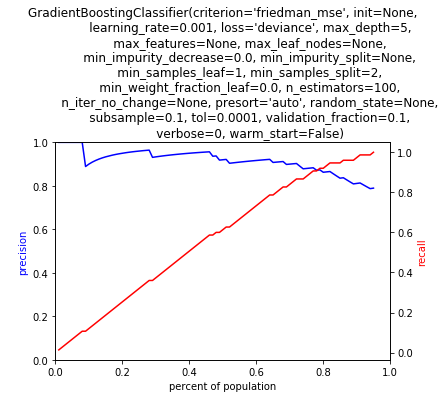

<Figure size 432x288 with 0 Axes>

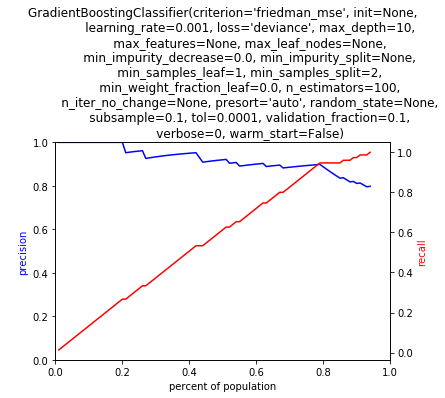

<Figure size 432x288 with 0 Axes>

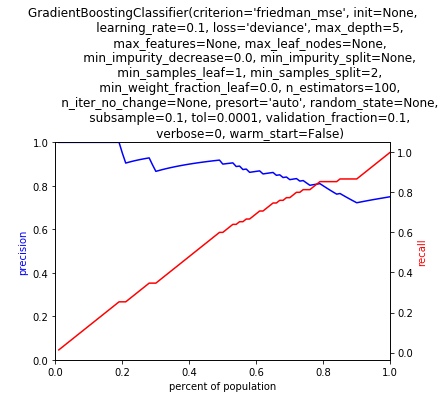

<Figure size 432x288 with 0 Axes>

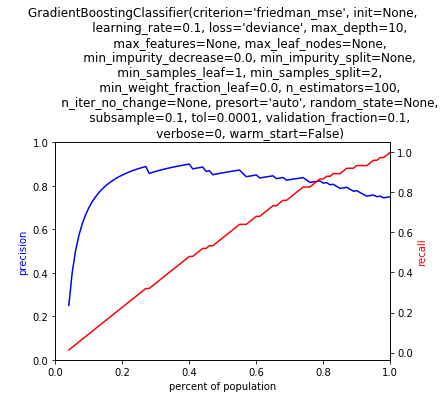

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

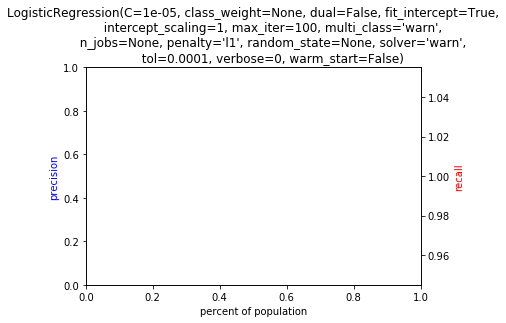

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

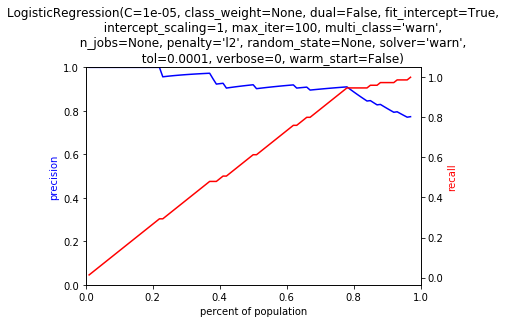

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

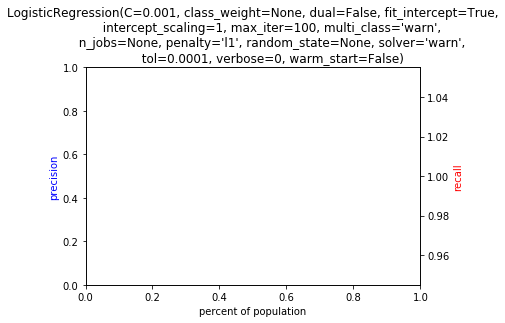

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

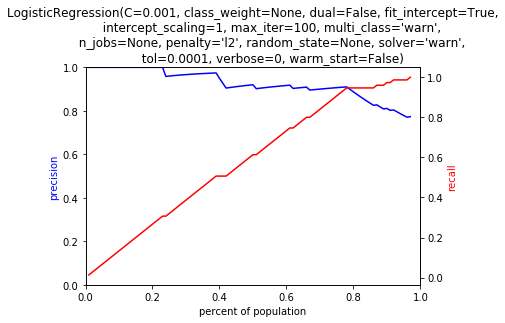

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

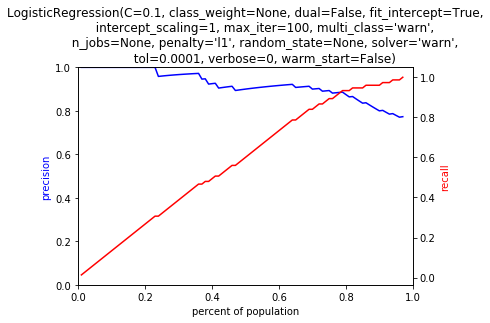

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

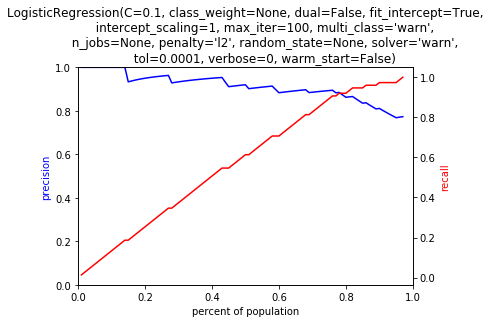

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

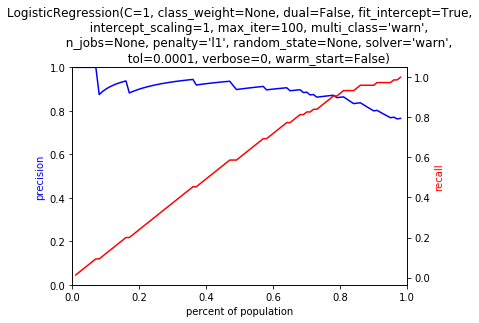

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

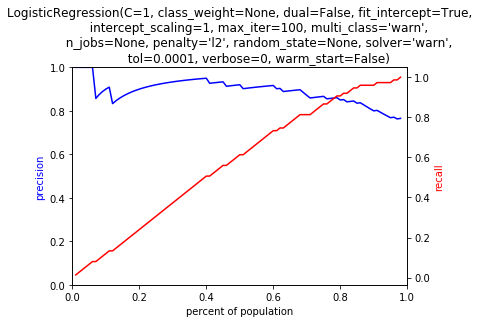

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

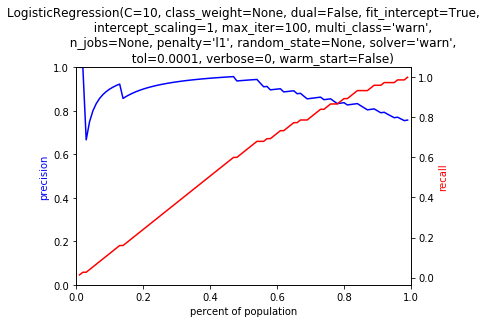

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

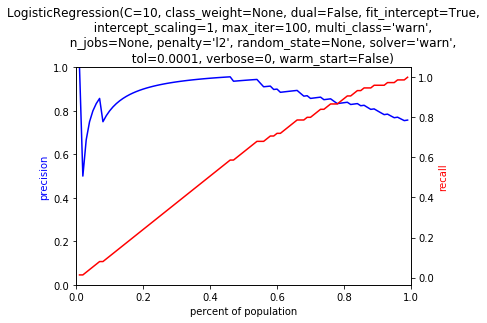

In [363]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df = clf_loop(models_to_run, clfs, small_grid, X,Y)

GB


<Figure size 432x288 with 0 Axes>

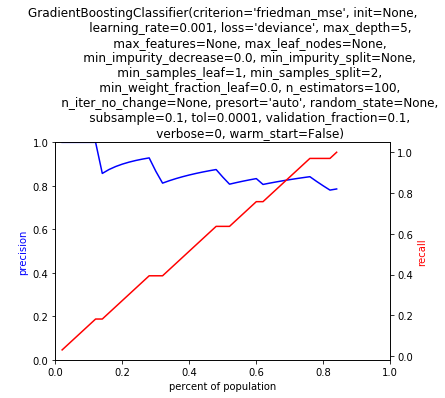

<Figure size 432x288 with 0 Axes>

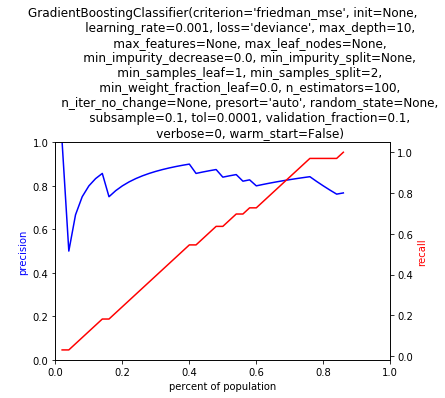

<Figure size 432x288 with 0 Axes>

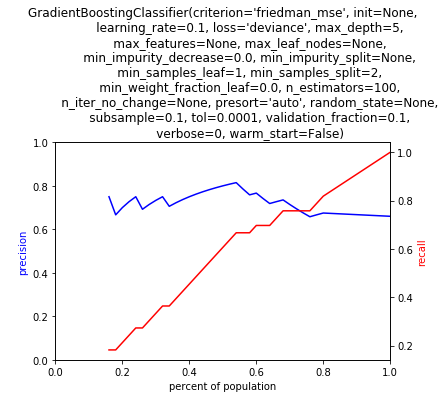

<Figure size 432x288 with 0 Axes>

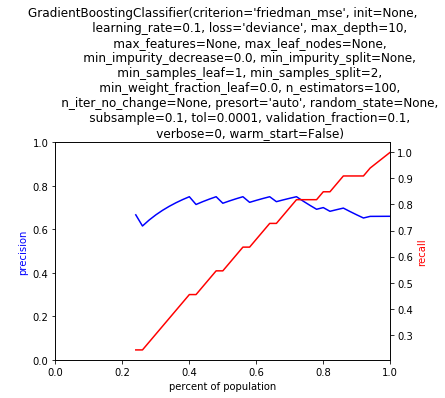

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

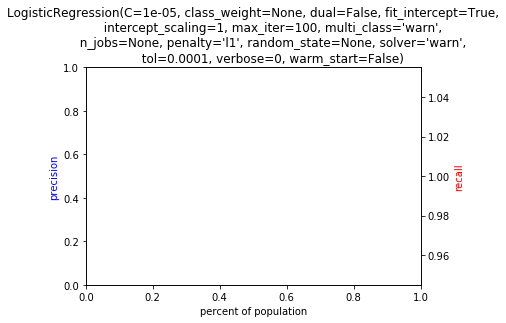

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

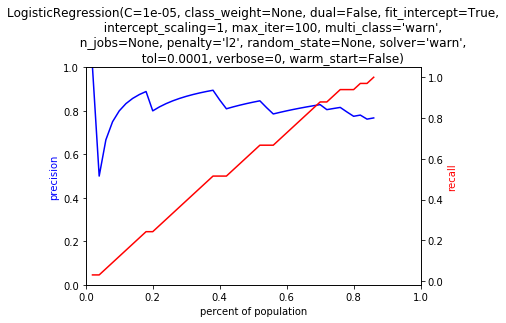

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

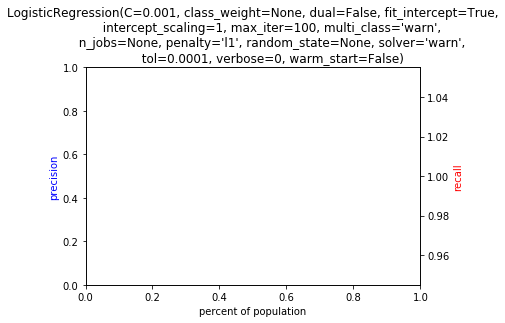

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

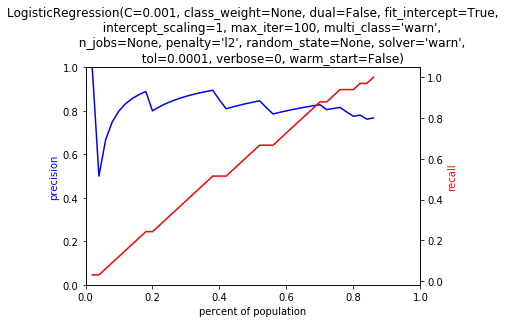

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

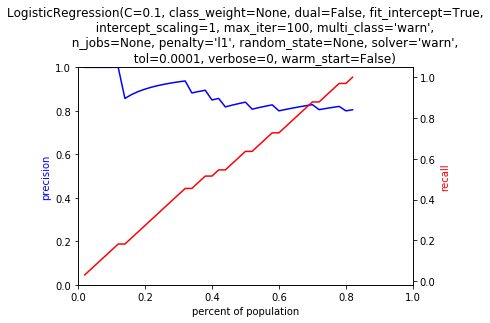

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

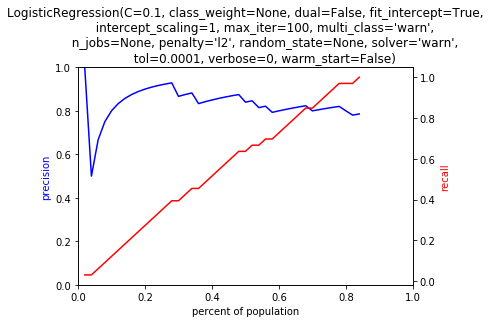

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

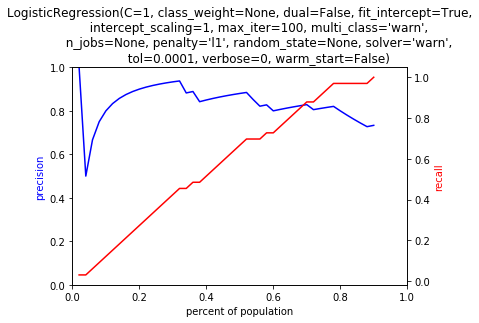

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

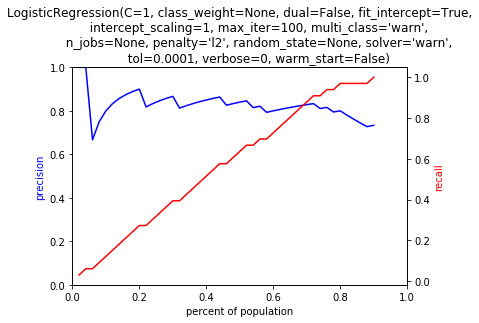

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

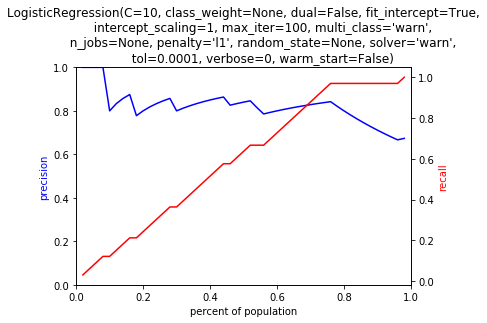

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

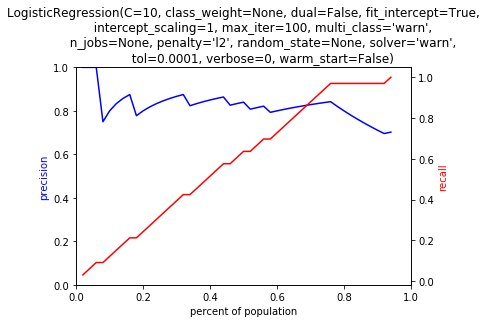

In [364]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df_non_singleton = clf_loop(models_to_run, clfs, small_grid, X_non_singleton,Y_non_singleton)

In [365]:
results_df.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.95,0.950
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",1.00,0.950
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l1'}",0.90,0.950
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l1'}",0.90,0.950
7,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l2'}",1.00,0.950
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",0.95,0.950
11,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",0.90,0.950
12,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l1'}",0.90,0.950
13,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l2'}",0.90,0.950
5,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l2'}",1.00,0.925


In [366]:
results_df_non_singleton.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.8,0.90
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l1'}",0.9,0.90
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l1'}",0.9,0.90
0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.9,0.85
5,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l2'}",0.8,0.85
7,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l2'}",0.8,0.85
8,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l1'}",0.9,0.85
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",0.9,0.85
10,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l1'}",0.9,0.85
11,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",0.9,0.85


# Lessons Nov 16 2018

+ We want to recommend about 300 people per day out of 2000, so we want to maximize precision_at k=20%. 
+ Most of these models seem to do that. I am staying with LR and GB because LR is very simple and GB is used elsewhere (and can be explained).
+ LR c=0.1, penatly=l1, seems to be the very best.
+ however this is still a bit sensitive to whether singletons are included. So we may want to limit to those who have 2 or more edits. In which case I want to do the following before settling on the model.

## Next steps is train more non-singletons
+ I want to train about 100 more non-singletons to get to a set of about 250. Then we can determine and pickle the model.

In [222]:
for model, model_name in ((sklearn.ensemble.GradientBoostingClassifier(),'gradboost'),
                          (sklearn.linear_model.LogisticRegression(), 'logreg')):
    kfold = sklearn.model_selection.KFold(n_splits=4, random_state=17)
    scoring = 'precision'
    CVresults = sklearn.model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    print(f"Model: {model_name}")
    print(f"CVresults: {CVresults}")

Model: gradboost
CVresults: [0.80327869 0.87837838 0.85245902 0.86792453]
Model: logreg
CVresults: [0.81666667 0.86486486 0.84482759 0.8627451 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [223]:
lr_results = model.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [224]:
coefs = lr_results.coef_.flatten().tolist()

In [225]:
named_coefs = zip(mapper.transformed_names_[:len(coefs)], coefs)

In [226]:
sorted_named_coefs = sorted(named_coefs, key=lambda tup: tup[1])

In [227]:
for name, coef in sorted_named_coefs:
    print(name,coef)

goodfaith_scores_count_log -0.6907753975039195
goodfaith_timestamps_total_seconds -0.6522985111364304
goodfaith_timestamps_variance -0.5725209825526096
goodfaith_scores_var -0.5273417990711292
first_edit_ores_damaging -0.3609775416569781
pages_unique_count -0.3065078227546845
pages_talk_count -0.24237916613934873
first_edit_ores_goodfaith -0.20571841261941615
edit_wars -0.19559735636383924
singleton_session -0.15910583520740978
goodfaith_scores_reg_intercept -0.14792278978140902
goodfaith_timestamps_min 0.0
any_edit_ores_goodfaith 0.10178567273021324
goodfaith_scores_count 0.10526466931395338
goodfaith_scores_reg_slope 0.14964421372063968
pages_namespace_count 0.19826285115728043
self_reverts 0.26347888397927405
pages_nonmain_count 0.28485952723581415
goodfaith_scores_min 0.29913227145110627
any_edit_ores_damaging 0.36699895003806754
goodfaith_scores_max 0.3877917066279402
goodfaith_scores_mean 0.8048764171208767
goodfaith_timestamps_max 1.449411478531078


In [ ]:
sorted_named_coefs

## Results
1. Logistic regression works well enough and CV doesn't show overfitting.
1. Feature importance show
    1. the maximum time in beteen edits indicates good faith (like a long contemplate edit?) (note that singleton-sessions have an imputed value of zero here, so needs to be checked)
    1. The mean, and variance of the goodfaith scores comes in at number 2, which are the simplest mathematical thing you could do as a meta-classifier.
    1. Then we have the number of edits in a session being poor indicator. Does this mean that vandalism happens in bursts? Or that COI editing likewise? Or that revert-wars show up here? I have seen such a thing in my own labelling, but didn't put my finger on it.
    1. Number 4 is total seconds, and surprisingly longer sessions are worse thought?


## Todo:
1. confusion matrix. Where goodfaith sessions wherer composed of badfaith edits? 22 out of 189
1. try for damaging as well.